#Spark setup

In [ ]:
 # Install Spark 3.0.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
# Install findspark
!python -m pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
APP_NAME = "Capstone"
SPARK_URL = "local[*]"

In [ ]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [ ]:
spark

#Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Loading Kaggle data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!kaggle datasets download -d asaniczka/tmdb-movies-dataset-2023-930k-movies

Dataset URL: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
License(s): ODC Attribution License (ODC-By)
 99% 195M/197M [00:11<00:00, 23.6MB/s]
100% 197M/197M [00:11<00:00, 17.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tmdb-movies-dataset-2023-930k-movies.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#put csv into pandas dataframe
location = '/content/TMDB_movie_dataset_v11.csv'
TMDB_movie = pd.read_csv(location)
TMDB_movie.drop(columns=['backdrop_path', 'homepage', 'overview', 'poster_path', 'tagline'], inplace=True)

# Save the updated DataFrame back to the CSV file
TMDB_movie.to_csv(location, index=False)

TMDB_movie.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,popularity,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,tt1375666,en,Inception,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,tt0816692,en,Interstellar,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,tt0468569,en,The Dark Knight,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,tt0499549,en,Avatar,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,tt0848228,en,The Avengers,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


#Data Preprocessing

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, BooleanType

# Load the DataFrame with the explicit schema
spark_df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
spark_df.show(5)
spark_df.printSchema()

+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|          title|vote_average|vote_count|  status|release_date|   revenue|runtime|adult|   budget|  imdb_id|original_language| original_title|popularity|              genres|production_companies|production_countries|    spoken_languages|            keywords|
+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 27205|      Inception|       8.364|     34495|Released|  2010-07-15| 825532764|    148|False|160000000|tt1375666|               en|      Inception|    83.952|Action, Science F...|Legendary Picture...|

In [ ]:
from pyspark.sql.functions import to_date, col

#clean release date column
spark_df = spark_df.withColumn('Date_Released', to_date(col('release_date'), 'yyyy-MM-dd'))
spark_sorted = spark_df.sort(spark_df['Date_Released'].desc())
spark_dropped = spark_sorted.drop('release_date')
spark_dropped = spark_dropped.dropna(subset=['Date_Released'])
spark_dropped.show(5)

+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|     0|tt5174640|               en|           100 Years|     2.238|Drama, Science F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_vote_count = spark_dropped.filter(col('vote_count') == 0).count()
print(f"Number of rows where vote_count is 0: {zero_vote_count}")

Number of rows where vote_count is 0: 582645


In [ ]:
# Drop rows where vote_count is 0
#spark_dropped = spark_dropped.filter(col('vote_count') != 0)

# A true "movie" must be at least 75 minutes long?
#spark_dropped = spark_dropped.filter(col('runtime') >= 75)

spark_dropped = spark_dropped.dropna(subset=['Date_Released', 'imdb_id'])

spark_dropped.show(5)

from pyspark.sql.functions import count, when, min, max

# Print the number of rows
num_rows = spark_dropped.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(spark_dropped.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = spark_dropped.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_dropped.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in spark_dropped.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in spark_dropped.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|   budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|        0| tt5174640|               en|           100 Years|     2.238|Drama, Science Fi...|Troublemaker St

In [ ]:
import pyspark.sql.functions as F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_rev_count = spark_dropped.filter(col('revenue') == 0).count()
print(f"Number of rows where revenue_count is 0: {zero_rev_count}")

Number of rows where revenue_count is 0: 532375


In [ ]:
# Filter rows where vote_count is 0 and count them
zero_budg_count = spark_dropped.filter(col('budget') == 0).count()
print(f"Number of rows where budget_count is 0: {zero_budg_count}")

Number of rows where budget_count is 0: 514637


In [ ]:
#drop rows with revenue <= 1,000 & budge = 0
spark_rev = spark_dropped.filter((F.col('revenue').isNotNull()) & (F.col('revenue') > 0))
spark_budg = spark_rev.filter((F.col('budget').isNotNull()) & (F.col('budget') > 0))
spark_budg.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt33059737|               en|   Finding Her Voice|       1.4|        Drama, Music

In [ ]:
spark_budg.count()

10602

In [ ]:
from pyspark.sql.types import IntegerType, FloatType

#changing type to Integer
data_nums = spark_budg.withColumn("budget", F.col("budget").cast(IntegerType())) \
                .withColumn("revenue", F.col("revenue").cast(IntegerType())) \
                .withColumn("vote_average", F.col("vote_average").cast(FloatType())) \
                .withColumn("vote_count", F.col("vote_count").cast(IntegerType())) \
                .withColumn("runtime", F.col("runtime").cast(IntegerType())) \
                .withColumn("popularity", F.col("popularity").cast(FloatType()))
#varifying it worked
data_nums.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)



In [ ]:
#calculating profit with revenue and budget
profit = data_nums.withColumn('ProfitValue', data_nums.revenue - data_nums.budget)
profit.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt33059737|               en|   Finding Her V

In [ ]:
#registering the table to SQL
profit.createOrReplaceTempView("profit")

#showing profit count of negative profits
spark.sql("SELECT count(ProfitValue) FROM profit where ProfitValue < 0" ).show()

+------------------+
|count(ProfitValue)|
+------------------+
|              3421|
+------------------+



In [ ]:
from pyspark.sql.functions import when

#create a classification column for Profit True or False
profit_class = profit.withColumn("Profit_TorF",when(profit.ProfitValue > 0, 1).when(profit.ProfitValue <= 0, 0).otherwise(2))
profit_class.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt3305973

In [ ]:
from pyspark.sql.functions import split

#Parse out year of release date
parsed_date = profit_class.withColumn('Year_Released', split(profit_class['Date_Released'], '-').getItem(0))
parsed_date.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|1324984|   Finding Her Voice|         0.0|         0|     Relea

In [ ]:
from pyspark.sql.types import IntegerType, FloatType

#changing year type to Integer
parsed_date = parsed_date.withColumn("Year_Released", F.col("Year_Released").cast(IntegerType()))

#varifying it worked
parsed_date.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)
 |-- ProfitValue: integer (nullable = true)
 |-- Profit_TorF: integer (nullable = false)
 |-- Year_Released: integer (nullable = true)



In [ ]:
parsed_date.count()

10602

In [ ]:
from pyspark.sql.functions import when

#Creating a covid classification column pre and post covid
movie_classified = parsed_date.withColumn("Covid",when(parsed_date.Year_Released > 2019, 'Post').when(parsed_date.Year_Released <= 2019, 'Pre').otherwise('covid unknown'))
movie_classified.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|1324984|   Finding Her Voice|         0.0|   

In [ ]:
import requests
import gzip
import shutil
import pandas as pd
import numpy as np

# URL for the IMDB Non-Commercial Crew Members Dataset
url = 'https://datasets.imdbws.com/title.crew.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'title.crew.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('title.crew.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
title_crew = pd.read_csv('title.crew.tsv', delimiter='\t', low_memory=False)

# Display the DataFrame
title_crew.dtypes
title_crew['directors'] = title_crew['directors'].astype(str)
title_crew['first_director'] = title_crew['directors'].apply(lambda x: x.split(',')[0])
title_crew.drop(columns=['directors', 'writers'],axis=1, inplace=True)
title_crew.head()

,tconst,first_director
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690


In [ ]:
import requests
import gzip
import shutil
import pandas as pd

# URL for the IMDB Non-Commercial Person Dataset
url = 'https://datasets.imdbws.com/name.basics.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'name.basics.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('name.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t', low_memory=False)
name_basics.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Display the DataFrame
print(name_basics.head())

      nconst      primaryName                   primaryProfession  \
0  nm0000001     Fred Astaire        actor,miscellaneous,producer   
1  nm0000002    Lauren Bacall  actress,soundtrack,archive_footage   
2  nm0000003  Brigitte Bardot   actress,music_department,producer   
3  nm0000004     John Belushi       actor,writer,music_department   
4  nm0000005   Ingmar Bergman               writer,director,actor   

                            knownForTitles  
0  tt0072308,tt0050419,tt0053137,tt0027125  
1  tt0037382,tt0075213,tt0117057,tt0038355  
2  tt0057345,tt0049189,tt0056404,tt0054452  
3  tt0072562,tt0077975,tt0080455,tt0078723  
4  tt0050986,tt0083922,tt0050976,tt0069467  


In [ ]:
director = pd.merge(title_crew, name_basics, left_on='first_director', right_on='nconst', how='inner')
director.drop(columns=['nconst', 'first_director'], axis=1, inplace=True)
director.to_csv('/content/director.csv', index=False)

director_sdf = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/director.csv')
director_sdf.printSchema()
director_sdf.show(5)

root
 |-- tconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

+---------+--------------------+--------------------+--------------------+
|   tconst|         primaryName|   primaryProfession|      knownForTitles|
+---------+--------------------+--------------------+--------------------+
|tt0000001|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000005|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000006|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000007|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000008|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
movie_classified = movie_classified.join(director_sdf, movie_classified.imdb_id==director_sdf.tconst, how='left')
movie_classified = movie_classified.withColumnRenamed('primaryName', 'Director')
movie_classified = movie_classified.drop('tconst')
movie_classified.show(5)

+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+-----------+-----------+-------------+-----+---------------+--------------------+--------------------+
|    id|               title|vote_average|vote_count|  status|  revenue|runtime|adult| budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|  spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|       Director|   primaryProfession|      knownForTitles|
+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+----------------

#Exploratory Data Analysis

In [ ]:
from pyspark.sql.functions import col, count, when, min, max

# Print the number of rows
num_rows = movie_classified.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(movie_classified.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = movie_classified.select([count(when(col(c).isNull(), c)).alias(c) for c in movie_classified.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in movie_classified.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in movie_classified.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

print("\nTotal number of Numerical Columns in the dataset:",len(numerical_cols))
#for col_name in numerical_cols:
#    print(f"{col_name}:")

print("\nCategorical Columns:")
for col_name in categorical_cols:
    print(f"{col_name}:")

# Summary Notes about the Dataset
print("\nDataset Summary:")
movie_classified.summary().show()

Number of rows: 10602
Number of columns: 26
Null Counts in Each Column:
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
| id|title|vote_average|vote_count|status|revenue|runtime|adult|budget|imdb_id|original_language|original_title|popularity|genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|Director|primaryProfession|knownForTitles|
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
|  0|    0|           0|       

In [ ]:
#registering the table to SQL
movie_classified.createOrReplaceTempView("movie_classified")

#showing profit count of negative profits
spark.sql("Select y.Covid, (y.profit_yes/t.total_profit) as avg_profit_count from (Select Covid, count(Profit_TorF) as profit_yes FROM movie_classified where Profit_TorF = 1 group by Covid) as y Join (Select Covid, count(Profit_TorF) as total_profit FROM movie_classified group by Covid) as t where y.Covid = t.Covid").show()


+-----+------------------+
|Covid|  avg_profit_count|
+-----+------------------+
|  Pre|0.6557093425605537|
| Post|0.5077319587628866|
+-----+------------------+



#Visualization

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
data = movie_classified.toPandas()

In [ ]:
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Profit_TorF', 'Year_Released']
categorical_columns = ['genres', 'original_language', 'Director']

plot_budget_distribution.png already exists. Displaying the plot...


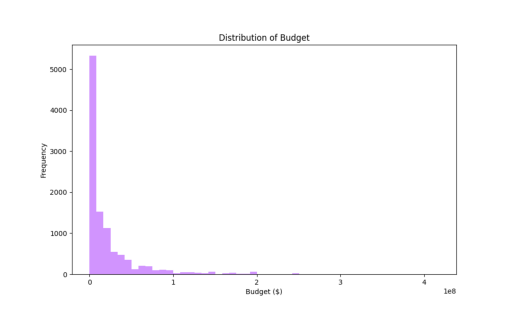

plot_revenue_distribution.png already exists. Displaying the plot...


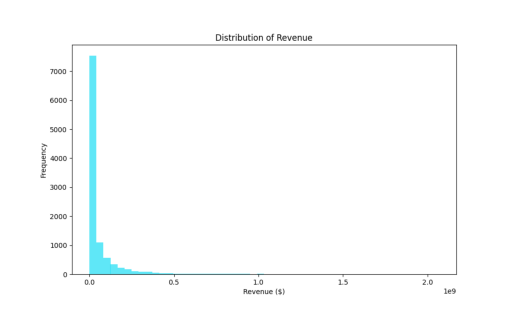

plot_rating_distribution.png already exists. Displaying the plot...


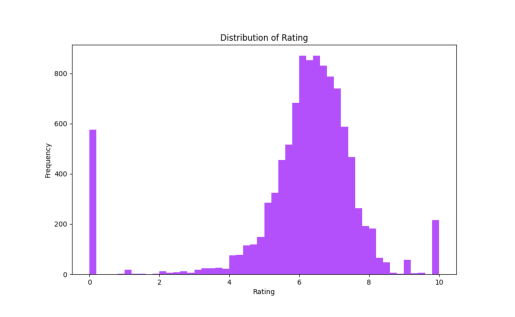

plot_release_year_distribution.png already exists. Displaying the plot...


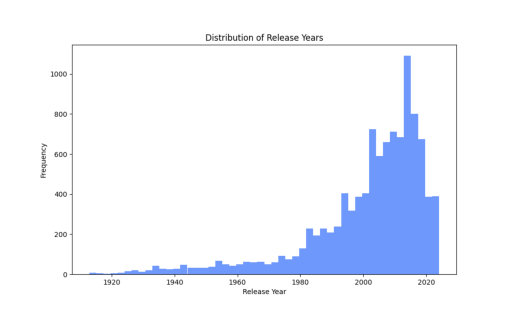

plot_budget_vs_revenue.png already exists. Displaying the plot...


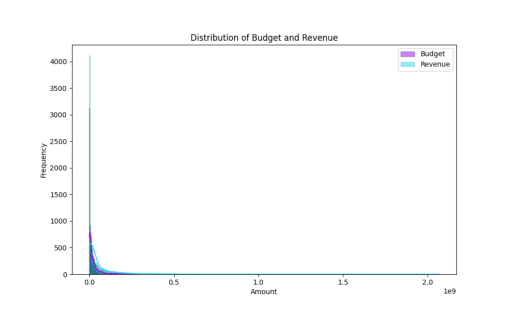

plot_release_year_vs_revenue.png already exists. Displaying the plot...


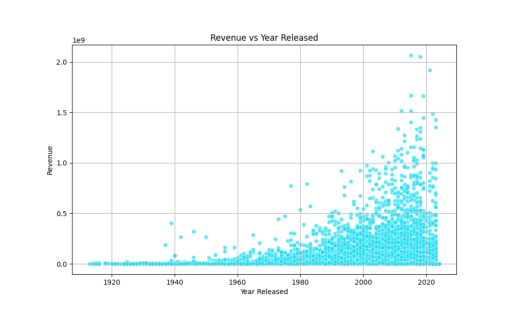

plot_release_year_vs_profit.png already exists. Displaying the plot...


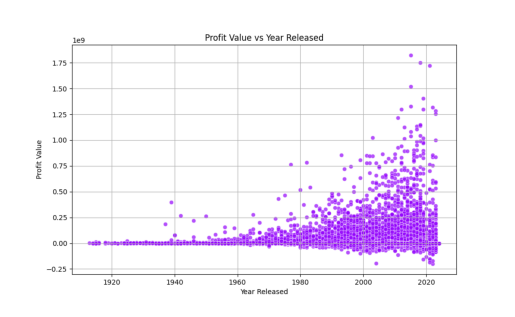

plot_release_year_vs_profitability.png already exists. Displaying the plot...


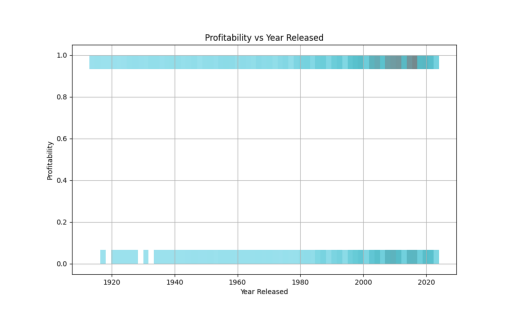

plot_profit_vs_rating.png already exists. Displaying the plot...


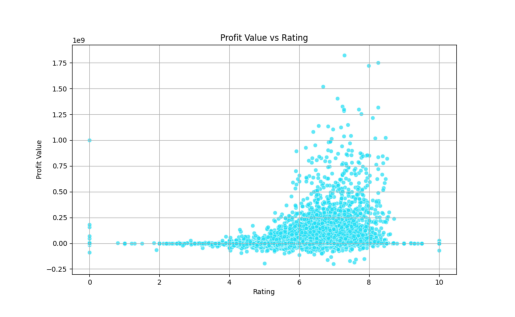

plot_revenue_vs_rating.png already exists. Displaying the plot...


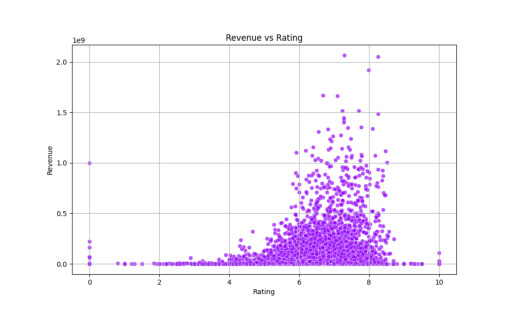

plot_budget_vs_rating.png already exists. Displaying the plot...


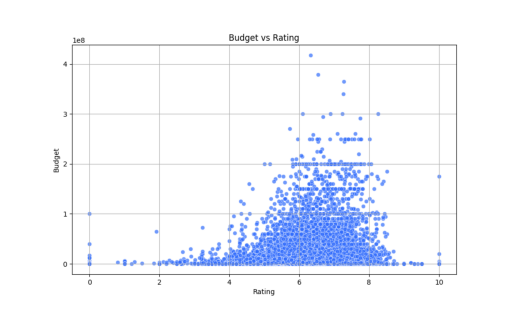

plot_correlation_matrix.png already exists. Displaying the plot...


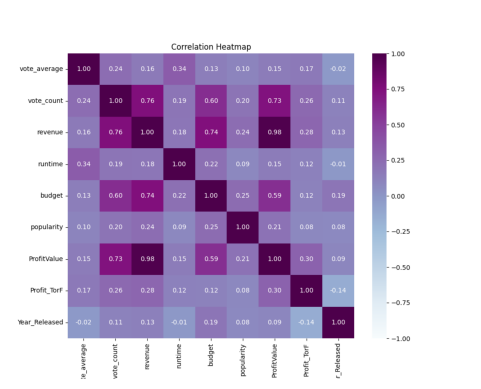

plot_encoded_correlation_matrix.png already exists. Displaying the plot...


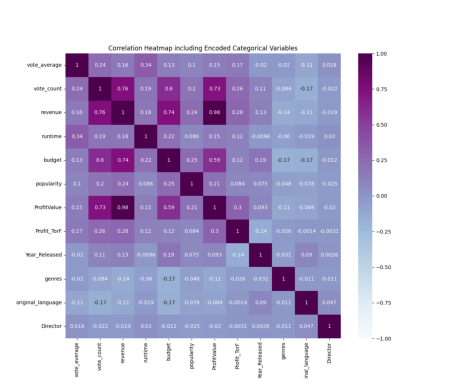

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to save or load a plot
def save_or_load_plot(plot_func, filename):
    # Create the 'visuals' directory if it doesn't exist
    visuals_dir = 'visuals'
    if not os.path.exists(visuals_dir):
        os.makedirs(visuals_dir)

    # Full path to save the plot
    full_path = os.path.join(visuals_dir, filename)

    if os.path.exists(full_path):
        print(f"{filename} already exists. Displaying the plot...")
        img = plt.imread(full_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axes for the image
        plt.show()
    else:
        print(f"Creating and saving {filename}...")
        plot_func()
        plt.savefig(full_path)
        plt.show()

# Define all plot functions

def plot_budget_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(data['budget'], bins=50, color='#be67fe', alpha=0.7)
    plt.title('Distribution of Budget')
    plt.xlabel('Budget ($)')
    plt.ylabel('Frequency')

def plot_revenue_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(data['revenue'], bins=50, color='#1bdef5', alpha=0.7)
    plt.title('Distribution of Revenue')
    plt.xlabel('Revenue ($)')
    plt.ylabel('Frequency')

def plot_rating_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(data['vote_average'], bins=50, color='#9405fc', alpha=0.7)
    plt.title('Distribution of Rating')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

def plot_release_year_distribution():
    plt.figure(figsize=(10, 6))
    plt.hist(data['Year_Released'], bins=50, color='#316cfc', alpha=0.7)
    plt.title('Distribution of Release Years')
    plt.xlabel('Release Year')
    plt.ylabel('Frequency')

def plot_budget_vs_revenue():
    plt.figure(figsize=(10, 6))
    sns.histplot(data['budget'], color='#9405fc', kde=True, label='Budget')
    sns.histplot(data['revenue'], color='#1bdef5', kde=True, label='Revenue')
    plt.title('Distribution of Budget and Revenue')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.legend()

def plot_release_year_vs_revenue():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Year_Released', y='revenue', data=data, color='#1bdef5', alpha=0.7)
    plt.title('Revenue vs Year Released')
    plt.xlabel('Year Released')
    plt.ylabel('Revenue')
    plt.grid(True)

def plot_release_year_vs_profit():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Year_Released', y='ProfitValue', data=data, color='#9405fc', alpha=0.7)
    plt.title('Profit Value vs Year Released')
    plt.xlabel('Year Released')
    plt.ylabel('Profit Value')
    plt.grid(True)

def plot_release_year_vs_profitability():
    plt.figure(figsize=(10, 6))
    sns.histplot(x='Year_Released', y='Profit_TorF', data=data, color='#1bdef5', alpha=0.7)
    plt.title('Profitability vs Year Released')
    plt.xlabel('Year Released')
    plt.ylabel('Profitability')
    plt.grid(True)

def plot_profit_vs_rating():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='vote_average', y='ProfitValue', data=data, color='#1bdef5', alpha=0.7)
    plt.title('Profit Value vs Rating')
    plt.xlabel('Rating')
    plt.ylabel('Profit Value')
    plt.grid(True)

def plot_revenue_vs_rating():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='vote_average', y='revenue', data=data, color='#9405fc', alpha=0.7)
    plt.title('Revenue vs Rating')
    plt.xlabel('Rating')
    plt.ylabel('Revenue')
    plt.grid(True)

def plot_budget_vs_rating():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='vote_average', y='budget', data=data, color='#316cfc', alpha=0.7)
    plt.title('Budget vs Rating')
    plt.xlabel('Rating')
    plt.ylabel('Budget')
    plt.grid(True)

def plot_correlation_matrix():
    #numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Profit_TorF', 'Year_Released']
    correlation_matrix = data[numerical_columns].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')

def plot_encoded_correlation_matrix():
    #numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Profit_TorF', 'Year_Released']
    #categorical_columns = ['genres', 'original_language', 'Director']

    df_encoded = data[numerical_columns + categorical_columns].copy()

    ordinal_encoder = OrdinalEncoder()
    df_encoded[categorical_columns] = ordinal_encoder.fit_transform(df_encoded[categorical_columns])

    corr_matrix = df_encoded.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='BuPu', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap including Encoded Categorical Variables')

# Use the save_or_load_plot function to handle each plot
save_or_load_plot(plot_budget_distribution, "plot_budget_distribution.png")
save_or_load_plot(plot_revenue_distribution, "plot_revenue_distribution.png")
save_or_load_plot(plot_rating_distribution, "plot_rating_distribution.png")
save_or_load_plot(plot_release_year_distribution, "plot_release_year_distribution.png")
save_or_load_plot(plot_budget_vs_revenue, "plot_budget_vs_revenue.png")
save_or_load_plot(plot_release_year_vs_revenue, "plot_release_year_vs_revenue.png")
save_or_load_plot(plot_release_year_vs_profit, "plot_release_year_vs_profit.png")
save_or_load_plot(plot_release_year_vs_profitability, "plot_release_year_vs_profitability.png")
save_or_load_plot(plot_profit_vs_rating, "plot_profit_vs_rating.png")
save_or_load_plot(plot_revenue_vs_rating, "plot_revenue_vs_rating.png")
save_or_load_plot(plot_budget_vs_rating, "plot_budget_vs_rating.png")
save_or_load_plot(plot_correlation_matrix, "plot_correlation_matrix.png")
save_or_load_plot(plot_encoded_correlation_matrix, "plot_encoded_correlation_matrix.png")

In [ ]:
# Explore outlier data and save to file
import os
from pyspark.sql.functions import col
import joblib
import pandas as pd

# Function to calculate IQR and detect outliers
def detect_outliers(df, column):
    # Calculate Q1 and Q3
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1

    # Calculate lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))

    return outliers

# Directory to save the results
results_dir = 'Outlier_Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# File to save the results
outliers_filename = os.path.join(results_dir, 'outliers_dict.pkl')

if os.path.exists(outliers_filename):
    print(f"Loading outliers from {outliers_filename}...")
    outliers_dict = joblib.load(outliers_filename)

    # Print the number of outliers for each feature
    for feature in numerical_columns:
        if feature in outliers_dict:
            outlier_count = len(outliers_dict[feature])
            print(f'Number of outliers in {feature}: {outlier_count}')

else:
    outliers_dict = {}
    for feature in numerical_columns:
        outliers = detect_outliers(movie_classified, feature)
        outlier_count = outliers.count()
        outliers_dict[feature] = outliers.toPandas()
        print(f'Number of outliers in {feature}: {outlier_count}')

    # Save outliers_dict to file
    joblib.dump(outliers_dict, outliers_filename)

# Function to print data in a DOS-type table format
def print_table(df, max_rows=10):
    if not df.empty:
        # Print the table header
        print("+", end="")
        print("-" * (len(df.columns) * 20 - 1), end="")
        print("+")

        # Print the column names
        for col_name in df.columns:
            print(f"| {col_name[:18]:<18}", end=" ")
        print("|")

        # Print the table separator
        print("+", end="")
        print("-" * (len(df.columns) * 20 - 1), end="")
        print("+")

        # Print the rows
        for i, row in df.head(max_rows).iterrows():
            for value in row:
                print(f"| {str(value)[:18]:<18}", end=" ")
            print("|")

        # Print the table footer
        print("+", end="")
        print("-" * (len(df.columns) * 20 - 1), end="")
        print("+")

# Show a few outliers for each feature to inspect in a table format
for feature, outliers in outliers_dict.items():
    print(f"\nOutliers for {feature}:")
    print_table(outliers)

# Union all outliers into a single DataFrame for inspection
all_outliers = None
for feature, outliers in outliers_dict.items():
    if all_outliers is None:
        all_outliers = outliers
    else:
        all_outliers = pd.concat([all_outliers, outliers]).drop_duplicates()

print(f'Total number of unique outliers: {len(all_outliers)}')

# Show a few combined outliers to inspect in a table format
if not all_outliers.empty:
    print("\nCombined outliers from all features:")
    print_table(all_outliers)


Loading outliers from Outlier_Results/outliers_dict.pkl...
Number of outliers in vote_average: 1012
Number of outliers in vote_count: 1273
Number of outliers in revenue: 1395
Number of outliers in runtime: 967
Number of outliers in budget: 1023
Number of outliers in popularity: 633
Number of outliers in ProfitValue: 1660
Number of outliers in Profit_TorF: 0
Number of outliers in Year_Released: 645

Outliers for vote_average:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| id                 | title              | vote_

#Machine Learning

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
ml_df = movie_classified.select('vote_average', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue','Profit_TorF', 'Year_Released', 'Covid', 'genres', 'Director')
ml_df.show(5)
ml_df.count()

+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+
|vote_average|  revenue|runtime| budget|popularity|ProfitValue|Profit_TorF|Year_Released|Covid|              genres|       Director|
+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+
|         5.0|  5916000|    105| 388000|     1.582|    5528000|          1|         1928|  Pre|        Drama, Music|    Lloyd Bacon|
|       8.332| 11000000|    125|2000000|    20.506|    9000000|          1|         1940|  Pre|         Comedy, War|Charles Chaplin|
|         6.2| 15000000|    139|5000000|     9.846|   10000000|          1|         1954|  Pre|      History, Drama| Michael Curtiz|
|        6.85| 14000000|    102|4300000|    16.695|    9700000|          1|         1968|  Pre|      Crime, Romance| Norman Jewison|
|        6.39|116019547|    120|7200000|    33.045|  108819547|      

10602

In [ ]:
ml_df = ml_df.dropna()
ml_df.count()

10422

In [ ]:
cols = ['genres', 'Director', 'Covid']

stages = [StringIndexer(inputCol = column, outputCol = column +"_index").fit(ml_df) for column in cols]


Features = ['vote_average', 'runtime', 'budget', 'popularity', 'Year_Released']
stages.append(VectorAssembler(inputCols=Features, outputCol='Features'))

pipeline = Pipeline(stages=stages)
transformed = pipeline.fit(ml_df).transform(ml_df)

transformed.show(5)

+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+------------+--------------+-----------+--------------------+
|vote_average|  revenue|runtime| budget|popularity|ProfitValue|Profit_TorF|Year_Released|Covid|              genres|       Director|genres_index|Director_index|Covid_index|            Features|
+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+------------+--------------+-----------+--------------------+
|         5.0|  5916000|    105| 388000|     1.582|    5528000|          1|         1928|  Pre|        Drama, Music|    Lloyd Bacon|        38.0|         403.0|        0.0|[5.0,105.0,388000...|
|       8.332| 11000000|    125|2000000|    20.506|    9000000|          1|         1940|  Pre|         Comedy, War|Charles Chaplin|       269.0|         183.0|        0.0|[8.33199977874755...|
|         6.2| 15000000|    13

In [ ]:
collist = transformed.columns

In [ ]:
collist

['vote_average',
 'revenue',
 'runtime',
 'budget',
 'popularity',
 'ProfitValue',
 'Profit_TorF',
 'Year_Released',
 'Covid',
 'genres',
 'Director',
 'genres_index',
 'Director_index',
 'Covid_index',
 'Features']

In [ ]:
transformed.select('Features').take(1)

[Row(Features=DenseVector([5.0, 105.0, 388000.0, 1.582, 1928.0]))]

In [ ]:
train, test = transformed.randomSplit([0.8, 0.2], seed=1)

print(train.count(), test.count())

8330 2092


In [ ]:
#filtering lines to just those labeled as Pre Covid
pre_df = transformed.filter(col('Covid') == 'Pre')
pre_df.show(5)
pre_df.count()

+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+------------+--------------+-----------+--------------------+
|vote_average|  revenue|runtime| budget|popularity|ProfitValue|Profit_TorF|Year_Released|Covid|              genres|       Director|genres_index|Director_index|Covid_index|            Features|
+------------+---------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+---------------+------------+--------------+-----------+--------------------+
|         5.0|  5916000|    105| 388000|     1.582|    5528000|          1|         1928|  Pre|        Drama, Music|    Lloyd Bacon|        38.0|         403.0|        0.0|[5.0,105.0,388000...|
|       8.332| 11000000|    125|2000000|    20.506|    9000000|          1|         1940|  Pre|         Comedy, War|Charles Chaplin|       269.0|         183.0|        0.0|[8.33199977874755...|
|         6.2| 15000000|    13

9687

In [ ]:
pre_train, pre_test = pre_df.randomSplit([0.8, 0.2], seed=1)

print(pre_train.count(), pre_test.count())

7732 1955


In [ ]:
#filtering lines to just those labeled as Post Covid
post_df = transformed.filter(col('Covid') == 'Post')
post_df.show(5)
post_df.count()

+------------+-------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+--------------+------------+--------------+-----------+--------------------+
|vote_average|revenue|runtime| budget|popularity|ProfitValue|Profit_TorF|Year_Released|Covid|              genres|      Director|genres_index|Director_index|Covid_index|            Features|
+------------+-------+-------+-------+----------+-----------+-----------+-------------+-----+--------------------+--------------+------------+--------------+-----------+--------------------+
|       6.512|2543216|     96|5000000|    31.143|   -2456784|          0|         2022| Post|Horror, Mystery, ...|   Chloe Okuno|        23.0|        2297.0|        1.0|[6.51200008392334...|
|         0.0|   1000|     13|    500|       0.6|        500|          1|         2021| Post|               Drama|Piet W. Mundry|         0.0|        1562.0|        1.0|[0.0,13.0,500.0,0...|
|        10.0|      1|      2|      5|       

735

In [ ]:
post_train, post_test = post_df.randomSplit([0.8, 0.2], seed=1)

print(post_train.count(), post_test.count())

597 138


In [ ]:
# Baseline Model (Golden) Code for combined, pre, and post Covid data which doesn't save the models themselves just their results
# I don't think we need to save the models as we won't need to refer to them later

import os
import pickle
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Function to save results
def save_results(filename, results):
    results_path = os.path.join("Baseline_Runs", filename + "_results.pkl")
    with open(results_path, 'wb') as f:
        pickle.dump(results, f)

# Function to load results if they exist
def load_results(filename):
    results_path = os.path.join("Baseline_Runs", filename + "_results.pkl")
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        return results
    return None

# Create the directory for storing baseline runs if it doesn't exist
results_dir = "Baseline_Runs"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# List of dataset pairs
datasets = [
    ('train', 'test'),
    ('pre_train', 'pre_test'),
    ('post_train', 'post_test')
]

input_size = len(Features)

# Models to run
models = {
    'RandomForest': RandomForestClassifier(labelCol='Profit_TorF', featuresCol='Features'),
    'LogisticRegression': LogisticRegression(labelCol='Profit_TorF', featuresCol='Features'),
    'MLP': MultilayerPerceptronClassifier(labelCol='Profit_TorF', featuresCol='Features', layers=[input_size, 64, 32, 16, 8, 4, 2])
}

# Iterate over datasets and models
for train_name, test_name in datasets:
    train = eval(train_name)
    test = eval(test_name)

    for model_name, model in models.items():
        filename = f"{model_name}_{train_name}_{test_name}"

        # Check if results already exist
        results = load_results(filename)
        if results:
            print(f"Loaded results for {model_name} on {train_name}, {test_name} from {filename}")
        else:
            # Fit model
            trained_model = model.fit(train)
            predict = trained_model.transform(test)

            # Evaluate model
            evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
            auc = evaluator.evaluate(predict)

            multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
            accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
            precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
            recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

            results = {
                'AUC-ROC': auc,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall
            }

            # Save results
            save_results(filename, results)
            print(f"Saved results for {model_name} on {train_name}, {test_name} to {filename}")

        # Print results
        print(f"{model_name} results for {train_name}, {test_name}:")
        for metric, value in results.items():
            print(f"{metric}: {value:.4f}")
        print("\n")


Loaded results for RandomForest on train, test from RandomForest_train_test
RandomForest results for train, test:
AUC-ROC: 0.6759
Accuracy: 0.6594
Precision: 0.6622
Recall: 0.6594


Loaded results for LogisticRegression on train, test from LogisticRegression_train_test
LogisticRegression results for train, test:
AUC-ROC: 0.5694
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000


Loaded results for MLP on train, test from MLP_train_test
MLP results for train, test:
AUC-ROC: 0.4605
Accuracy: 0.4783
Precision: 0.4655
Recall: 0.4783


Loaded results for RandomForest on pre_train, pre_test from RandomForest_pre_train_pre_test
RandomForest results for pre_train, pre_test:
AUC-ROC: 0.7739
Accuracy: 0.7243
Precision: 0.7119
Recall: 0.7243


Loaded results for LogisticRegression on pre_train, pre_test from LogisticRegression_pre_train_pre_test
LogisticRegression results for pre_train, pre_test:
AUC-ROC: 0.7293
Accuracy: 0.6675
Precision: 0.6360
Recall: 0.6675


Loaded results for MLP on pre_tra

Baseline_Runs/RandomForest_train_test_results.pkl
Baseline_Runs/LogisticRegression_train_test_results.pkl
Baseline_Runs/MLP_train_test_results.pkl
Baseline_Runs/RandomForest_pre_train_pre_test_results.pkl
Baseline_Runs/LogisticRegression_pre_train_pre_test_results.pkl
Baseline_Runs/MLP_pre_train_pre_test_results.pkl
Baseline_Runs/RandomForest_post_train_post_test_results.pkl
Baseline_Runs/LogisticRegression_post_train_post_test_results.pkl
Baseline_Runs/MLP_post_train_post_test_results.pkl


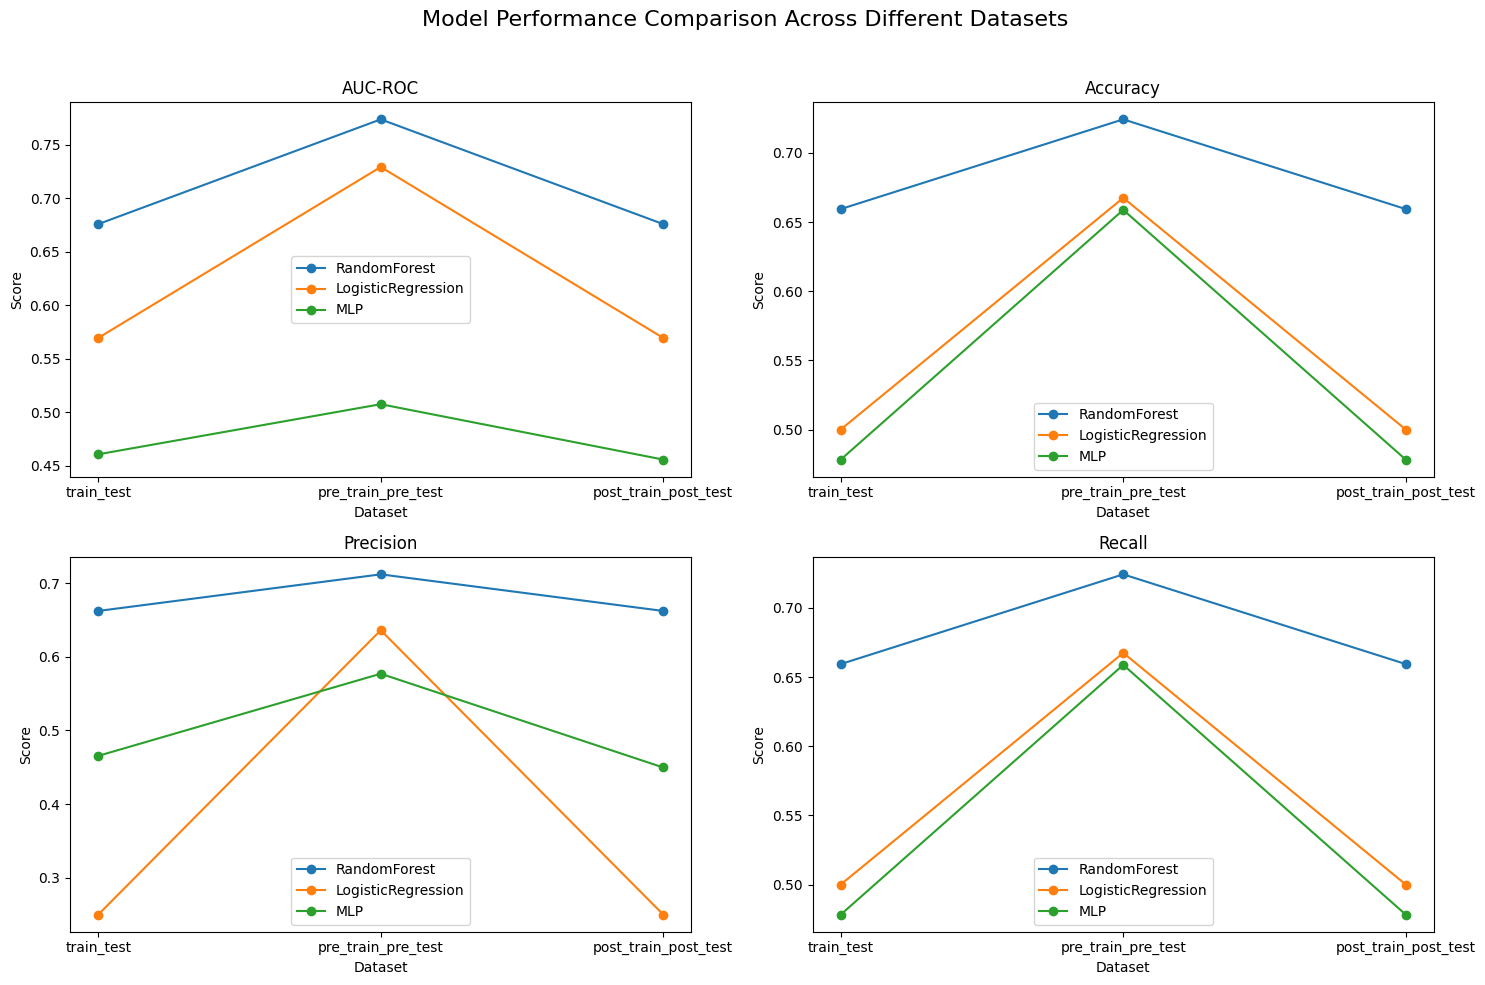

In [ ]:
# Charts of Base model metrics comparisons
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Function to load results
def load_results(filename):
    results_dir = "Baseline_Runs"
    #results_path = filename + "_results.pkl"
    results_path = os.path.join(results_dir, f'{filename}_results.pkl')
    print(results_path)
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        return results
    return None

# List of dataset pairs
datasets = [
    ('train', 'test'),
    ('pre_train', 'pre_test'),
    ('post_train', 'post_test')
]

# Models to load
models = ['RandomForest', 'LogisticRegression', 'MLP']

# Prepare data for comparison
comparison_data = []

for train_name, test_name in datasets:
    for model_name in models:
        filename = f"{model_name}_{train_name}_{test_name}"
        results = load_results(filename)
        if results:
            for metric, value in results.items():
                comparison_data.append({
                    'Model': model_name,
                    'Dataset': f"{train_name}_{test_name}",
                    'Metric': metric,
                    'Value': value
                })

# Convert to DataFrame for easier plotting
df = pd.DataFrame(comparison_data)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison Across Different Datasets', fontsize=16)

# Plot each metric
metrics = ['AUC-ROC', 'Accuracy', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    for model_name in models:
        subset = df[(df['Model'] == model_name) & (df['Metric'] == metric)]
        ax.plot(subset['Dataset'], subset['Value'], marker='o', label=model_name)
    ax.set_title(metric)
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Score')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


##Feature Importance

In [ ]:
collist

['vote_average',
 'revenue',
 'runtime',
 'budget',
 'popularity',
 'ProfitValue',
 'Profit_TorF',
 'Year_Released',
 'Covid',
 'genres',
 'Director',
 'genres_index',
 'Director_index',
 'Covid_index',
 'Features']

In [ ]:
#Feature Importance
#Random Forest Pre-Covid
rf = RandomForestClassifier(labelCol='Profit_TorF', featuresCol='Features')
modelrfpre = rf.fit(pre_train)
dictfi_rfpre = {}
for feature, importance in zip(collist, modelrfpre.featureImportances):
    dictfi_rfpre[feature] = importance
    print(f"{feature}:{importance}")

vote_average:0.1928062943207761
revenue:0.06331383623437324
runtime:0.09687627044406118
budget:0.45422541052868487
popularity:0.19277818847210448


In [52]:
print(modelrfpre.featureImportances)

(5,[0,1,2,3,4],[0.1928062943207761,0.06331383623437324,0.09687627044406118,0.45422541052868487,0.19277818847210448])


In [ ]:
#Feature Importance
#Random Forest Post-Covid
rf = RandomForestClassifier(labelCol='Profit_TorF', featuresCol='Features')
modelrfpost = rf.fit(post_train)
dictfi_rfpost = {}
for feature, importance in zip(collist, modelrfpost.featureImportances):
    dictfi_rfpost[feature] = importance
    print(f"{feature}:{importance}")

vote_average:0.20599526507418445
revenue:0.1529488850741392
runtime:0.1882461622376529
budget:0.40460708462118367
popularity:0.048202602992839856


##KFold Cross Validation

In [ ]:
#This is hopefully the golden version that creates a directory to store the files
import os
import joblib
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, mean_squared_error
import numpy as np

# Define dataset pairs
dataset_pairs = [
    ('train', 'test', 'combined'),
    ('pre_train', 'pre_test', 'pre_covid'),
    ('post_train', 'post_test', 'post_covid')
]

# Define models and parameter grids
models = {
    'random_forest': (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'logistic_regression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    'neural_network': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01],
        'early_stopping': [True]
    })
}

# Outer K-Fold
outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Directory to save the models and metrics
results_dir = 'CrossFold_Tuning_Runs'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Loop through each dataset pair
for train_name, test_name, data_label in dataset_pairs:
    print(f"\nProcessing {data_label} dataset...")

    # Check if model and metric files already exist for all models in the current dataset pair
    model_files_exist = all(os.path.exists(os.path.join(results_dir, f'{data_label}_{model_name}_model.pkl')) for model_name in models)
    metrics_files_exist = all(os.path.exists(os.path.join(results_dir, f'{data_label}_{model_name}_metrics.txt')) for model_name in models)

    if model_files_exist and metrics_files_exist:
        print(f"All models and metrics for {data_label} dataset already exist. Loading metrics...")

        # Load and print each metric file
        for model_name in models:
            metrics_filename = os.path.join(results_dir, f'{data_label}_{model_name}_metrics.txt')
            print(f"\nMetrics for {model_name} ({data_label} dataset):")

            with open(metrics_filename, 'r') as f:
                metrics_content = f.read()
                print(metrics_content)

    else:
        print(f"Training and evaluating models for {data_label} dataset...")

        # Load train and test datasets
        train = globals()[train_name]
        test = globals()[test_name]

        X_train = np.array(train.select('Features').collect()).squeeze()
        y_train = np.array(train.select('Profit_TorF').collect()).ravel()
        X_test = np.array(test.select('Features').collect()).squeeze()
        y_test = np.array(test.select('Profit_TorF').collect()).ravel()

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Save scaler
        scaler_filename = os.path.join(results_dir, f'{data_label}_scaler.pkl')
        joblib.dump(scaler, scaler_filename)

        outer_results = {}
        test_results = {}

        for model_name, (model, param_grid) in models.items():
            model_filename = os.path.join(results_dir, f'{data_label}_{model_name}_model.pkl')
            metrics_filename = os.path.join(results_dir, f'{data_label}_{model_name}_metrics.txt')

            outer_fold_results = {'mse': [], 'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': []}

            for train_index, val_index in outer_kf.split(X_train_scaled):
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                # Inner K-Fold for hyperparameter tuning
                inner_kf = KFold(n_splits=5, shuffle=True, random_state=42)
                grid_search = GridSearchCV(model, param_grid, cv=inner_kf, scoring='neg_mean_squared_error')
                grid_search.fit(X_train_fold, y_train_fold)

                # Best model from inner CV
                best_model = grid_search.best_estimator_

                # Evaluate on outer fold
                y_pred = best_model.predict(X_val_fold)
                y_pred_proba = best_model.predict_proba(X_val_fold)[:, 1] if hasattr(best_model, "predict_proba") else None

                outer_fold_results['mse'].append(mean_squared_error(y_val_fold, y_pred))
                outer_fold_results['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba) if y_pred_proba is not None else np.nan)
                outer_fold_results['accuracy'].append(accuracy_score(y_val_fold, y_pred))
                outer_fold_results['precision'].append(precision_score(y_val_fold, y_pred))
                outer_fold_results['recall'].append(recall_score(y_val_fold, y_pred))

            # Save cross-validation metrics
            outer_results[model_name] = {metric: np.mean(scores) for metric, scores in outer_fold_results.items()}

            with open(metrics_filename, 'w') as f:
                f.write(f"Cross-Validation Results for {model_name} ({data_label}):\n")
                for metric, score in outer_results[model_name].items():
                    f.write(f"  {metric}: {score:.4f}\n")
                    print(f"  {metric}: {score:.4f}")

            # Save the best model
            joblib.dump(best_model, model_filename)

            # Evaluate on the test set
            y_test_pred = best_model.predict(X_test_scaled)
            y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

            test_results[model_name] = {
                'mse': mean_squared_error(y_test, y_test_pred),
                'roc_auc': roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else np.nan,
                'accuracy': accuracy_score(y_test, y_test_pred),
                'precision': precision_score(y_test, y_test_pred),
                'recall': recall_score(y_test, y_test_pred)
            }

            with open(metrics_filename, 'a') as f:
                f.write(f"\nTest Results for {model_name} ({data_label}):\n")
                for metric, score in test_results[model_name].items():
                    f.write(f"  {metric}: {score:.4f}\n")
                    print(f"  {metric}: {score:.4f}")



Processing combined dataset...
All models and metrics for combined dataset already exist. Loading metrics...

Metrics for random_forest (combined dataset):
Cross-Validation Results for random_forest (combined):
  mse: 0.4105
  roc_auc: 0.6364
  accuracy: 0.5895
  precision: 0.5982
  recall: 0.5944

Test Results for random_forest (combined):
  mse: 0.3841
  roc_auc: 0.6595
  accuracy: 0.6159
  precision: 0.6143
  recall: 0.6232


Metrics for logistic_regression (combined dataset):
Cross-Validation Results for logistic_regression (combined):
  mse: 0.4122
  roc_auc: 0.6234
  accuracy: 0.5878
  precision: 0.6217
  recall: 0.5311

Test Results for logistic_regression (combined):
  mse: 0.5000
  roc_auc: 0.5656
  accuracy: 0.5000
  precision: 0.5000
  recall: 0.4203


Metrics for neural_network (combined dataset):
Cross-Validation Results for neural_network (combined):
  mse: 0.4221
  roc_auc: 0.6096
  accuracy: 0.5779
  precision: 0.5916
  recall: 0.5994

Test Results for neural_network (

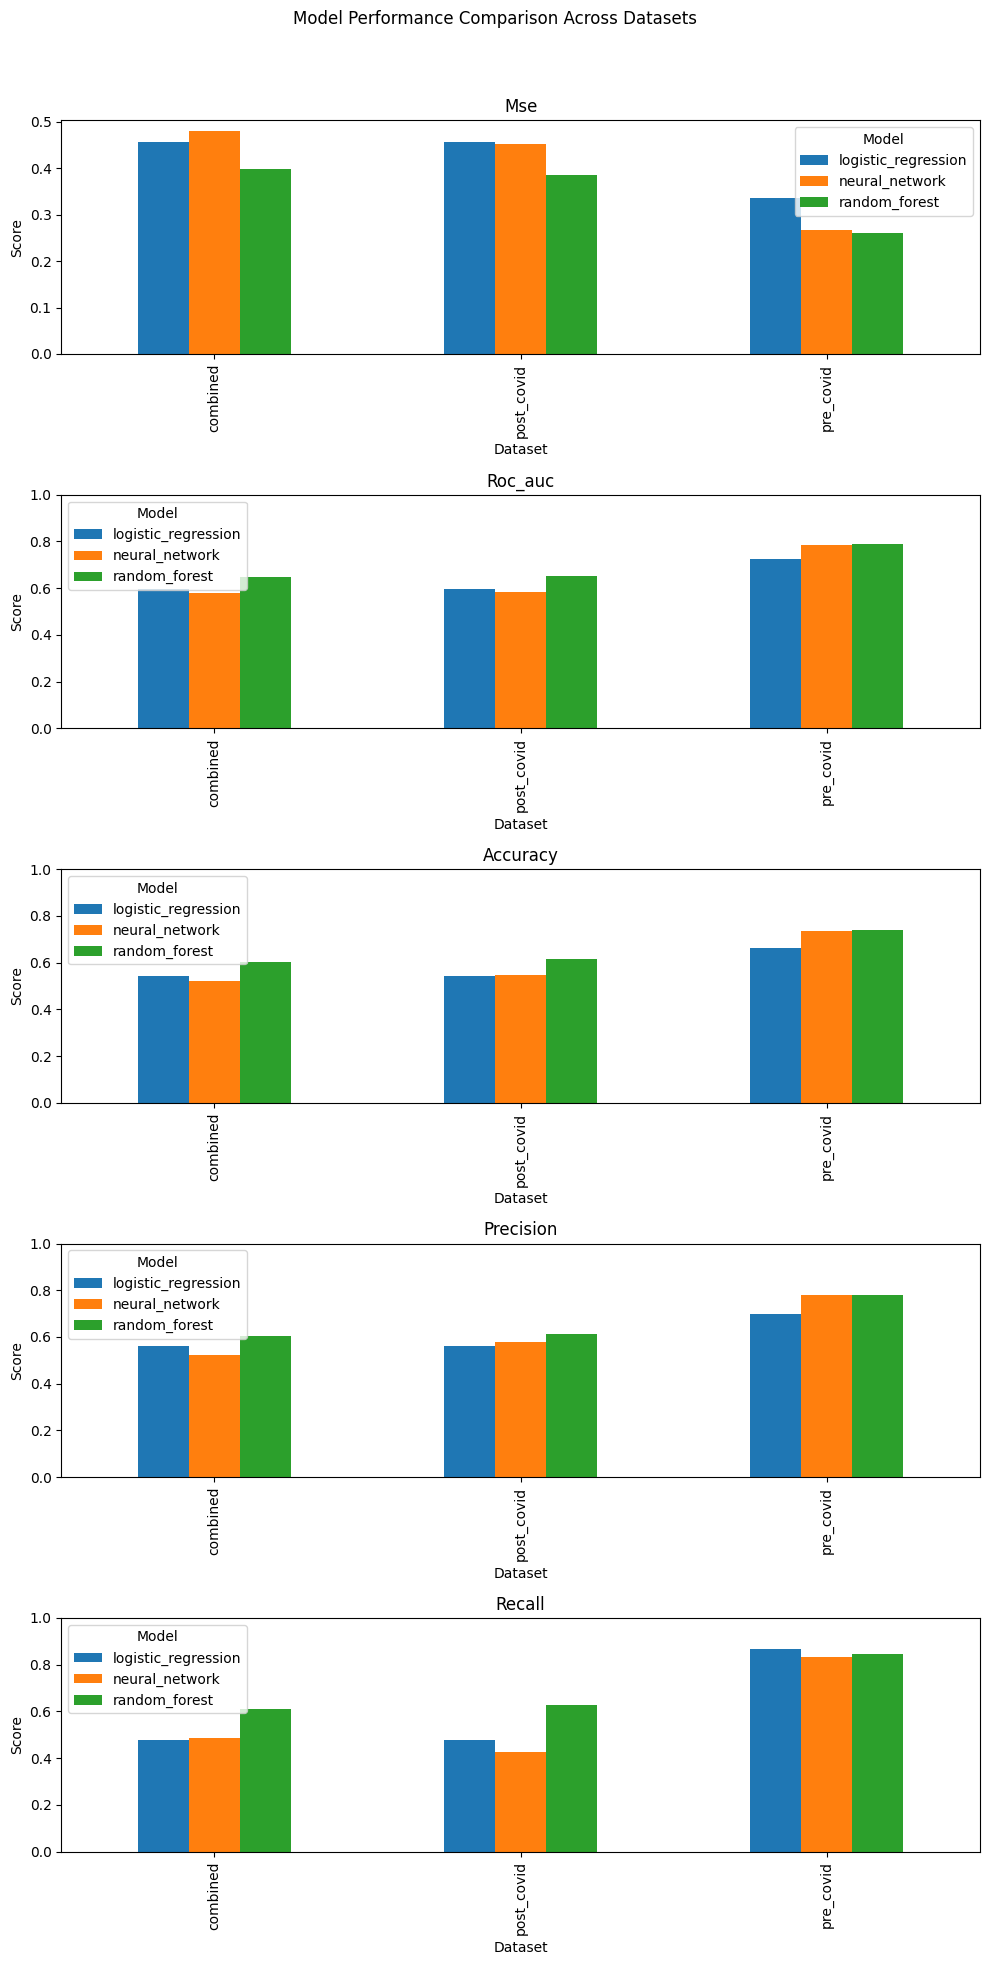

In [ ]:
# Chart comparision of models metrics after K-fold cross validation, tuning, and scaling
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define dataset pairs and models
dataset_pairs = ['combined', 'pre_covid', 'post_covid']
models = ['random_forest', 'logistic_regression', 'neural_network']
metrics = ['mse', 'roc_auc', 'accuracy', 'precision', 'recall']

# Initialize a list to store the results as dictionaries
results_list = []

# Directory that contains the results
results_dir = 'CrossFold_Tuning_Runs'

# Read the metrics files
for data_label in dataset_pairs:
    for model_name in models:
        #metrics_filename = f'{data_label}_{model_name}_metrics.txt'
        metrics_filename = os.path.join(results_dir, f'{data_label}_{model_name}_metrics.txt')

        if os.path.exists(metrics_filename):
            with open(metrics_filename, 'r') as f:
                lines = f.readlines()

            # Extract the metric scores from the file
            for metric in metrics:
                for line in lines:
                    if metric in line:
                        score = float(line.split(': ')[1].strip())
                        # Append result as a dictionary to the list
                        results_list.append({
                            'Dataset': data_label,
                            'Model': model_name,
                            'Metric': metric,
                            'Score': score
                        })


# Create DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Pivot the DataFrame for plotting
pivot_df = results_df.pivot_table(index=['Metric', 'Dataset'], columns='Model', values='Score')

# Plot the results
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 20))
fig.suptitle('Model Performance Comparison Across Datasets')

for i, metric in enumerate(metrics):
    pivot_df.loc[metric].plot(kind='bar', ax=axs[i])
    axs[i].set_title(metric.capitalize())
    axs[i].set_ylabel('Score')
    axs[i].set_ylim(0, 1 if metric != 'mse' else None)  # Assuming scores range between 0 and 1 except for MSE

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
